
# Lojistik Regresyon ile Diyabet Tahmini

## Problem:

Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirebilir misiniz?

Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

## Değişkenler

- **Pregnancies**: Hamilelik sayısı
- **Glucose**: Glikoz.
- **BloodPressure**: Kan basıncı.
- **SkinThickness**: Cilt Kalınlığı
- **Insulin**: İnsülin.
- **BMI**: Beden kitle indeksi.
- **DiabetesPedigreeFunction**: Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.
- **Age**: Yaş (yıl)
- **Outcome**: Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

## Uygulanacak Adımlar;

**1. Exploratory Data Analysis = Keşifsel Veri Analizi**

**2. Data Preprocessing = Veri Ön İşleme**

**3. Model & Prediction = Model ve Tahmin**

**4. Model Evaluation = Model Değerlendirme**

**5. Model Validation: Holdout = Model Doğrulama: Bekletme**

**6. Model Validation: 5-Fold Cross Validation = Model Doğrulama: 5 Katlı Çapraz Doğrulama**

**7. Prediction for A New Observation = Yeni Bir Gözlem için Tahmin**


### NOT = "Precision ve Recall" değeri önemli öğren



Bu kod bloğu, gerekli kütüphaneleri import eder ve her bir import satırında hangi amaçla kullanıldığını açıklar.

In [1]:
# Veriyi görselleştirmek ve grafik çizimleri için matplotlib kütüphanesini kullan
import matplotlib.pyplot as plt

# Nümerik hesaplamalar ve veri manipülasyonu için numpy ve pandas kütüphanelerini kullan
import numpy as np
import pandas as pd

# Veriyi çekici ve bilgilendirici şekilde görselleştirmek için seaborn kütüphanesini kullan
import seaborn as sns

# RobustScaler kullanarak ölçeklendirme yapmak için scikit-learn kütüphanesinden preprocessing modülünü kullan
from sklearn.preprocessing import RobustScaler

# Lojistik regresyon modeli oluşturmak için scikit-learn kütüphanesinden linear_model modülünü kullan
from sklearn.linear_model import LogisticRegression

# Sınıflandırma performans metrikleri, görselleştirmeleri ve veriyi bölmek, çapraz doğrulama yapmak için scikit-learn kütüphanesinden metrics ve model_selection modüllerini kullan
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_validate


Bu fonksiyonun amacı, veri çerçevesinde belirli bir sütunun aykırı değer sınırlarını hesaplamaktır. Çeyreklik değerleri (quartiles) ve interquartile range (IQR) kullanılarak üst ve alt sınırlar belirlenir. Varsayılan olarak, alt sınır çeyrek 1'in %5'ine, üst sınır çeyrek 3'ün %95'ine karşılık gelir. Ancak, bu değerler fonksiyona argüman olarak verilerek özelleştirilebilir.

In [2]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Veri çerçevesindeki belirli bir sütunun aykırı değer sınırlarını hesaplayan fonksiyon.

    Parameters:
    - dataframe: Veri çerçevesi
    - col_name: Aykırı değer sınırlarını hesaplamak istediğiniz sütunun adı
    - q1: Alt sınırı belirlemek için kullanılacak çeyrek 1 değeri (varsayılan: 0.05)
    - q3: Üst sınırı belirlemek için kullanılacak çeyrek 3 değeri (varsayılan: 0.95)

    Returns:
    - low_limit: Aykırı değerlerin alt sınırı
    - up_limit: Aykırı değerlerin üst sınırı
    """
    # Sütundaki verilerin çeyreklik değerlerini hesapla
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)

    # Çeyreklik aralığı (IQR) hesapla
    interquantile_range = quartile3 - quartile1

    # Üst ve alt sınırları hesapla
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range

    return low_limit, up_limit


Bu fonksiyon, önceden tanımlanan **outlier_thresholds** fonksiyonunu kullanarak belirli bir sütundaki aykırı değer sınırlarını belirler. Daha sonra, bu sınırlar içinde yer almayan herhangi bir değer varsa (**any(axis=None)** ile kontrol edilir), sütunun aykırı değer içerdiği sonucunu döndürür. Bu durumda **True** değeri döner, aksi takdirde **False** değeri döner.

In [3]:
def check_outlier(dataframe, col_name):
    """
    Veri çerçevesindeki belirli bir sütunun aykırı değer içerip içermediğini kontrol eden fonksiyon.

    Parameters:
    - dataframe: Veri çerçevesi
    - col_name: Aykırı değer kontrolü yapmak istediğiniz sütunun adı

    Returns:
    - True: Sütun aykırı değer içeriyorsa
    - False: Sütun aykırı değer içermiyorsa
    """
    # Aykırı değer sınırlarını al
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)

    # Aykırı değer kontrolü yap
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True  # Aykırı değer içeriyorsa
    else:
        return False  # Aykırı değer içermiyorsa


Bu fonksiyon, belirli bir sütundaki aykırı değerleri, bu sütunun alt sınırından daha küçük olanları alt sınıra, üst sınırından daha büyük olanları üst sınıra eşitleyerek değiştirir. **loc** metodu kullanılarak bu değişiklikler gerçekleştirilir.

In [4]:
def replace_with_thresholds(dataframe, variable):
    """
    Belirli bir sütundaki aykırı değerleri, önceden hesaplanan sınırlarla değiştiren fonksiyon.

    Parameters:
    - dataframe: Veri çerçevesi
    - variable: Aykırı değerleri değiştirmek istediğiniz sütunun adı
    """
    # Aykırı değer sınırlarını al
    low_limit, up_limit = outlier_thresholds(dataframe, variable)

    # Aykırı değerleri sınırlarla değiştir
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


Bu kod parçası, **pandas** kütüphanesindeki **set_option** fonksiyonunu kullanarak DataFrame'in görüntülenme şeklini özelleştirir. 

In [5]:
# DataFrame içinde görüntülenecek maksimum sütun sayısını belirleme
pd.set_option('display.max_columns', None)

# DataFrame içindeki float değerlerin görüntülenme biçimini belirleme
# Float değerler üç ondalık basamağa kadar gösterilecektir
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# DataFrame'in görüntülenme genişliğini belirleme
# 500 piksel genişliğinde bir görüntü sağlanır
pd.set_option('display.width', 500)


## Keşifsel Veri Analizi

Bu kod parçası, **'pandas'** kütüphanesini **'pd'** takma adıyla içe aktarıp, ardından **'datasets/diabetes.csv**' dosyasından veri okuma işlemi gerçekleştirir. Okunan veriler, bir DataFrame olan **'df'** adlı değişkene atanır. Bu tip bir kod kullanılarak, CSV formatındaki veri setlerini pandas DataFrame'ine dönüştürebilir ve daha sonra bu DataFrame'i manipüle edebilirsiniz.

**NOT !** = Başlangıçta tüm gerekli kütüphaneleri içe aktardık. Bu adımlarda tekrar kütüphaneleri içe aktarmaya gerek yok fakat ben hangi kütüphaneyi nerde kullandığımızı görmek adına import edeceğim.

In [6]:
# pandas kütüphanesini 'pd' takma adıyla içe aktarın
import pandas as pd

# 'datasets/diabetes.csv' dosyasından veri okuma işlemi
# Okunan veriler 'df' adlı DataFrame'e atanır
df = pd.read_csv("datasets/diabetes.csv")

### Target'ın (Hedef) Analizi

Bu kod, **"Outcome"** sütunundaki değerlerin sayısını ve yüzdelik oranlarını hesaplar ve bunları görüntüler. İlk olarak, **value_counts()** fonksiyonu ile **"Outcome"** sütunundaki her bir değerin kaç kez geçtiğini gösteren bir Seri oluşturulur. Ardından, **seaborn** kütüphanesini kullanarak bu değerlerin sayılarını çubuk grafikle görselleştirilir. Son olarak, yüzdelik oranlarını hesaplamak için **len(df)** (veri setindeki toplam gözlem sayısı) kullanılarak yüzdelik hesaplamaları yapılır ve bu değerler ekrana yazdırılır.

Outcome
0    500
1    268
Name: count, dtype: int64


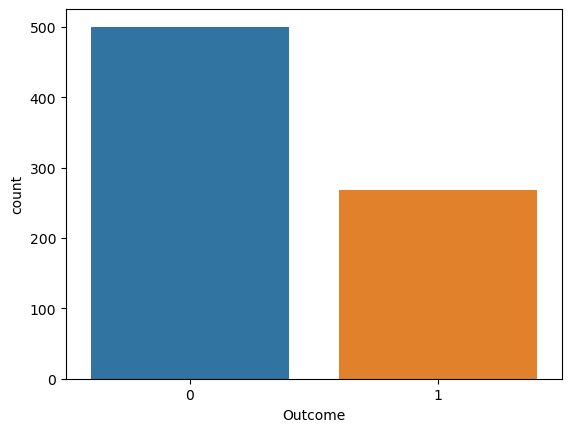

Outcome
0   65.104
1   34.896
Name: count, dtype: float64


In [7]:
# "Outcome" sütunundaki değerlerin sayısını görüntüleme
outcome_counts = df["Outcome"].value_counts()
print(outcome_counts)

# Seaborn kütüphanesini kullanarak "Outcome" sütunundaki değerlerin sayısını görselleştirme
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x="Outcome", data=df)
plt.show()

# "Outcome" sütunundaki değerlerin yüzdelik oranlarını görüntüleme
percentage_distribution = 100 * df["Outcome"].value_counts() / len(df)
print(percentage_distribution)


### Feature'ların (Özelliklerin) Analizi

Bu satır, veri setinin ilk beş satırını (**df.head()**) ekrana yazdırarak veri setini incelemenizi sağlar.

In [8]:
# Veri setinin ilk birkaç satırını görüntüleme
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


Bu satırlar, **"BloodPressure"** sütununun histogramını çizer. **hist()** fonksiyonu, bir sütunun dağılımını görselleştirmek için kullanılır. **bins** parametresi, histogramda kullanılacak çubuk sayısını belirtir. **plt.xlabel()** fonksiyonu ile x-ekseni etiketi belirlenir. Son olarak, **plt.show()** ile çizilen histogram ekrana getirilir. Bu grafik, "BloodPressure" sütunundaki değerlerin dağılımını gösterir.

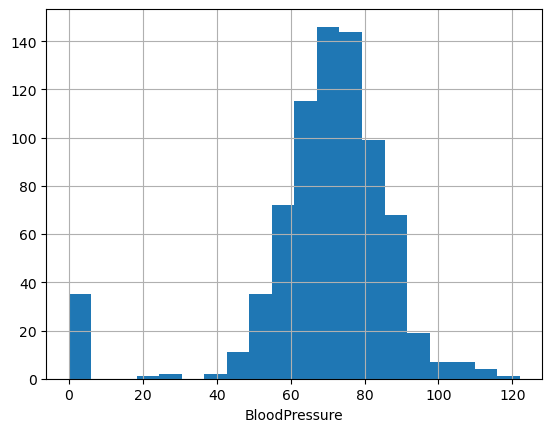

In [9]:
# "BloodPressure" sütununun histogramını çizme
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()


Bu fonksiyon, bir DataFrame ve sayısal bir sütun alır. Ardından, belirtilen sayısal sütunun histogramını çizer. Bu fonksiyon, belirli bir sayısal sütunun dağılımını hızlı bir şekilde görselleştirmek için kullanılabilir.

In [10]:
def plot_numerical_col(dataframe, numerical_col):
    """
    Belirtilen DataFrame içindeki bir sayısal sütunun histogramını çizen fonksiyon.

    Parameters:
    - dataframe: Histogramı çizilecek DataFrame
    - numerical_col: Histogramı çizilecek sayısal sütunun adı
    """
    # Belirtilen sayısal sütunun histogramını çizme
    dataframe[numerical_col].hist(bins=20)
    
    # x-ekseni etiketi belirleme
    plt.xlabel(numerical_col)
    
    # Histogramı ekrana gösterme 
    # block=true denme sebebi oluşturulacak histogramların birbirini ezmemesi
    plt.show(block=True)


Bu kod parçacığı, DataFrame'deki her sayısal sütunun histogramını çizer ve ardından **"Outcome"** kelimesini içermeyen sütunların histogramlarını çizmek için yorum satırındaki kodu kullanma seçeneği sunar. Son olarak, **df.describe().T** ile DataFrame'in sayısal sütunlarına ait istatistiksel özeti görüntüler.

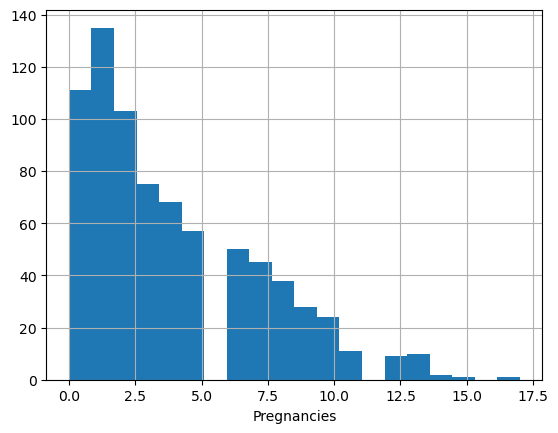

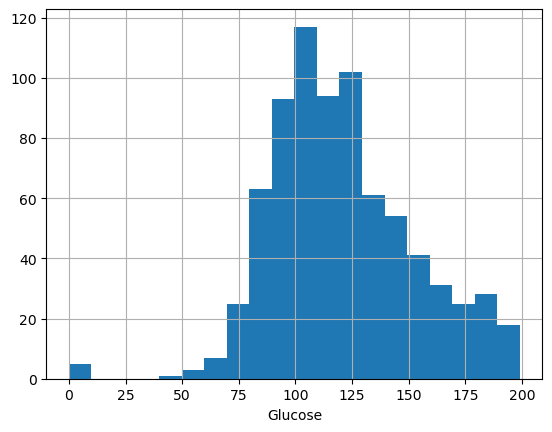

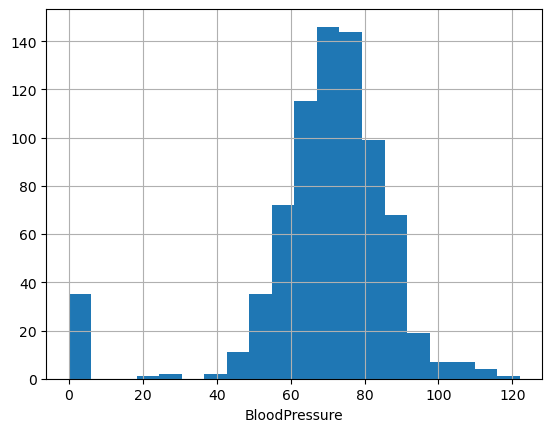

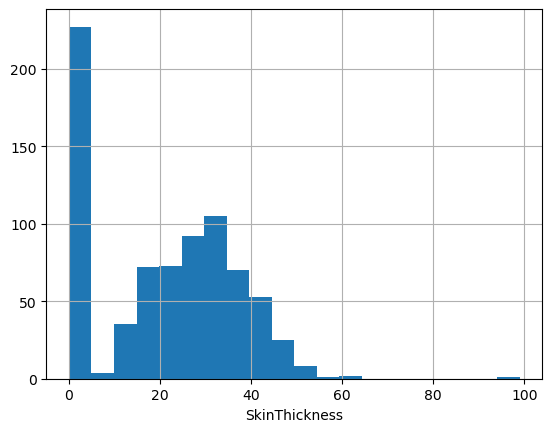

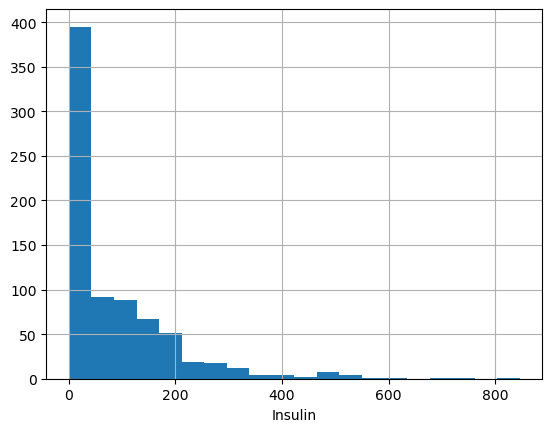

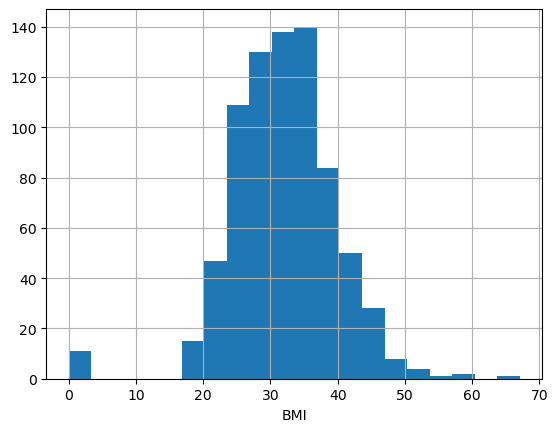

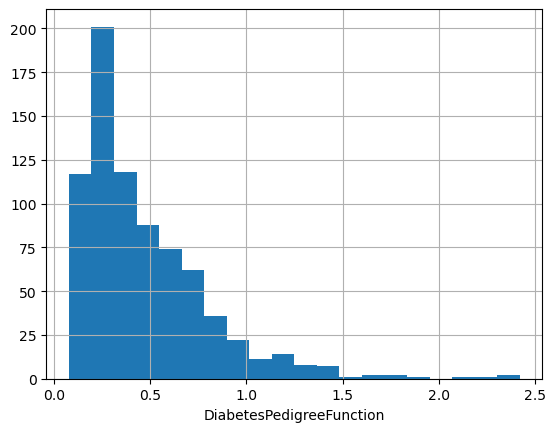

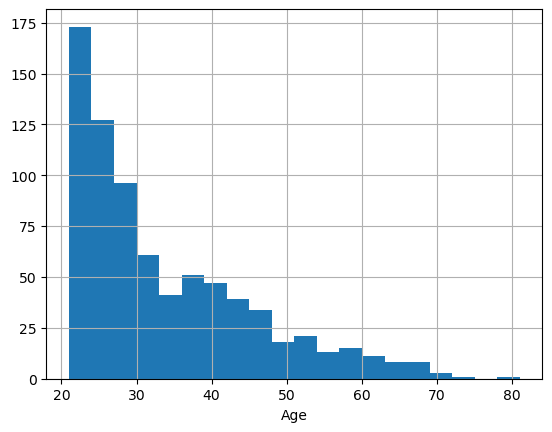

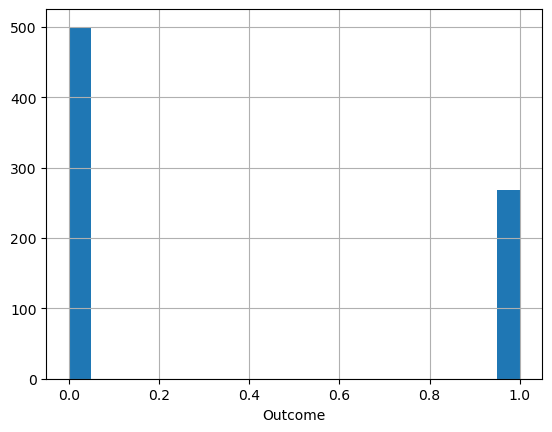

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [11]:
# DataFrame'deki her bir sayısal sütunun histogramını çizme
for col in df.columns:
    plot_numerical_col(df, col)

# "Outcome" kelimesi içermeyen sütunları seçme
cols = [col for col in df.columns if "Outcome" not in col]

# Seçilen sütunların histogramlarını çizme (Yorum satırındaki kodu kullanmak istiyorsanız)
# for col in cols:
#     plot_numerical_col(df, col)

# DataFrame'in sayısal sütunlarına ait istatistiksel özet
df.describe().T


### Target (Hedef) vs Features (Özellikler)

Bu kod, **"Outcome"** sütununa göre gruplandırılmış veri setindeki **"Pregnancies"** sütununun ortalamasını görüntüler. Ardından, **target_summary_with_num** fonksiyonu, her sayısal sütunun **"Outcome"** sütunu tarafından gruplandırılmış ortalamasını yazdırmak için kullanılır. Yorum satırındaki kod, tüm sayısal sütunlar için bu işlemi gerçekleştirmek içindir.

In [12]:
# "Outcome" sütununa göre gruplandırılmış veri setindeki "Pregnancies" sütununun ortalamasını görüntüleme
df.groupby("Outcome").agg({"Pregnancies": "mean"})

# target_summary_with_num fonksiyonunu tanımlama
def target_summary_with_num(dataframe, target, numerical_col):
    """
    Belirtilen DataFrame içindeki bir sayısal sütunu, hedef değişken tarafından gruplandırılmış ortalamasını yazdıran fonksiyon.

    Parameters:
    - dataframe: Ortalaması alınacak DataFrame
    - target: Hedef değişkenin adı (gruplandırma kriteri)
    - numerical_col: Ortalaması alınacak sayısal sütunun adı
    """
    # DataFrame'i "target" sütununa göre gruplandırıp, sayısal sütunun ortalamasını yazdırma
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

# "Outcome" kelimesini içermeyen sütunları seçme
cols = [col for col in df.columns if "Outcome" not in col]

# Her sayısal sütun için target_summary_with_num fonksiyonunu kullanma
for col in cols:
    target_summary_with_num(df, "Outcome", col)


         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




Bu verileri inceleyerek bağımsız değişkenler ile bağımlı değişken arasındaki bağlantıyı yorumlayabiliriz. Örneğin **Glucose** baktığımızda Diabet hastası olanların Glucose değeri ortalaması **141,257** iken, Diabet hastası olmayanların Glucose değeri ortalaması **109,98** olarak hesaplanmış. Yani yüksek oranda Glucose, Diabet hastalığı belirtisidir yorumunu çıkarabiliriz.

## Data Preprocessing (Veri Ön İşleme)

Bu kod parçası, veri seti üzerinde çeşitli veri ön işleme adımlarını içerir. Şekil ve başlangıçtaki veri ön izleme işlemleri, eksik değer kontrolü, istatistiksel özet, aykırı değer kontrolü, aykırı değer değiştirme ve sütunları RobustScaler kullanarak ölçeklendirme işlemleri gerçekleştirilir. Bu tür işlemler, veri setinin temizlenmesi ve modelleme sürecine hazır hale getirilmesi için yaygın olarak kullanılan adımlardır.

In [13]:
# Veri setinin şeklini görüntüleme
df.shape

(768, 9)

In [14]:
# Veri setinin ilk birkaç satırını yazdırma
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [15]:
# Eksik değerleri kontrol etme ve her sütundaki eksik değer sayısını görüntüleme
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [16]:
# Sayısal sütunların istatistiksel özetini görüntüleme
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


**Min** değerleri incelediğimizde sıfır olan veriler var. Muhtemelen ilgili sütunlarda eksik veriler olduğundan sıfır atanmış. Bu problemde bunları görmezden geleceğiz. 

In [17]:
# Aykırı değerleri kontrol etme ve her sayısal sütundaki aykırı değer durumunu yazdırma
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


Yukarıda birtek **Insulin True** olarak belirlenmiş. Yani Insulin sütunumuzda aykırı değerler var demektir. Bu aykırı değerleri aşağıdaki yöntem ile Insulin için belirlenen eşit değerler ile değiştereceğiz.

In [18]:
# "Insulin" sütunundaki aykırı değerleri belirlenen eşik değerlerle değiştirme
replace_with_thresholds(df, "Insulin")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1624\531118734.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-439.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit


Tekrar kontrol ettiğimizde **Insuline** sütunundaki aykırı değerlerin kaybolduğunu göreceğiz;

In [49]:
for col in cols:
    print(col, check_outlier(df, col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


In [19]:
# Her sayısal sütunu RobustScaler kullanarak ölçeklendirme
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

In [20]:
# Ölçeklendirilmiş veri setinin ilk birkaç satırını yazdırma
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


## Model & Prediction (Model ve Tahmin)

Bu kod parçası, **"Outcome"** sütununu hedef değişken olarak belirler, bağımsız değişkenleri seçer ve bir Lojistik Regresyon modeli oluşturup eğitir. Modelin sabit ve katsayılarını görüntüler. Ardından, tüm bağımsız değişkenlere göre tahminler yapar ve gerçek "Outcome" değerleri ile karşılaştırır. Bu, modelin performansını değerlendirmek için kullanılabilir.

In [22]:
# "Outcome" sütununu hedef değişken olarak seçme
y = df["Outcome"]

# "Outcome" sütununu hariç tutarak geri kalan sütunları bağımsız değişkenler olarak seçme
X = df.drop(["Outcome"], axis=1)

# Logistic Regression modelini oluşturup eğitme
log_model = LogisticRegression().fit(X, y)

In [23]:
# Modelin sabit (intercept) değerini görüntüleme
log_model.intercept_


array([-1.23439588])

In [24]:
# Modelin katsayılarını görüntüleme
log_model.coef_


array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [25]:
# Modelin bağımsız değişkenlere göre yaptığı tahminleri alıp ilk 10 tahmin değerini görüntüleme
y_pred = log_model.predict(X)
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0], dtype=int64)

In [26]:
# Gerçek "Outcome" değerlerini alıp ilk 10 değeri görüntüleme
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

### Model Evaluation (Model Değerlendirme)

Bu fonksiyon, gerçek ve tahmin edilen değerlere dayalı bir karışıklık matrisini görselleştirir ve doğruluk skorunu hesaplar. Ayrıca, **classification_report** fonksiyonu ile sınıflandırma raporunu yazdırır. Bu tür görselleştirmeler ve raporlar, bir sınıflandırma modelinin performansını değerlendirmek için kullanılır.

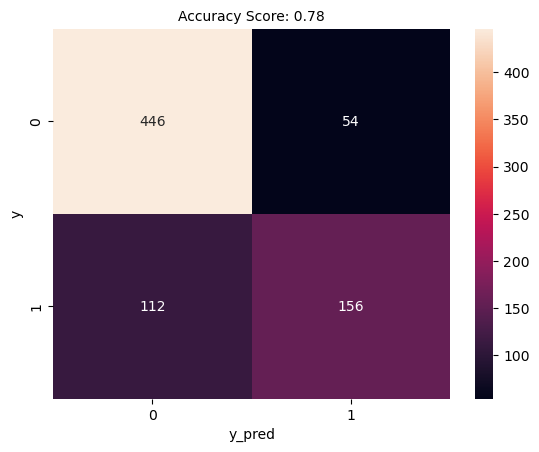

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [27]:
def plot_confusion_matrix(y, y_pred):
    """
    Confusion matrix ve accuracy score görselleştiren fonksiyon.

    Parameters:
    - y: Gerçek hedef değişken değerleri
    - y_pred: Model tarafından yapılan tahminler
    """
    # Accuracy score'u hesapla
    acc = round(accuracy_score(y, y_pred), 2)
    
    # Confusion matrix'i oluştur
    cm = confusion_matrix(y, y_pred)
    
    # Heatmap ile confusion matrix'i görselleştir
    sns.heatmap(cm, annot=True, fmt=".0f")
    
    # x-ekseni etiketi
    plt.xlabel('y_pred')
    
    # y-ekseni etiketi
    plt.ylabel('y')
    
    # Grafik başlığı
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    
    # Grafik gösterme
    plt.show()

# Confusion matrix ve accuracy score'u görselleştirme
plot_confusion_matrix(y, y_pred)

# Sınıflandırma raporunu yazdırma
print(classification_report(y, y_pred))


# !! Bizim için önemli olan parametereler;

- **Accuracy**: 0.78  ==> Başarı oranı, toplam doğru tahmin edilme oranı

- **Precision**: 0.74  ==> **Diabet olarak tahmin** edilenlerin gerçekte diabet olma oranı 

- **Recall**: 0.58  ==> **Gerçekte Diabet** (1) olanların Diabet olarak tahmin edilmesi

- **F1-score**: 0.65 ==> Performans ölüçümünde kullanılan bir metriktir. Hassasiyet (precision) ve duyarlılık (recall) değerlerini birleştiren bir ölçümdür.

**Hassasiyet (precision) ve duyarlılık (recall)**, özellikle dengesiz sınıflara sahip veri setlerinde performansı değerlendirmek için kullanılır. Eğer veri setinde Diabet olma ve olmama oranı %50-50 oranında olsaydı sadece Accuracy değerine bakarak yorum yapılabilirdir. Ancak bizim veri setimizde Diabet olmayan sayısı 500 iken Diabet sayısı 268 bu durumda diğer performans metriklerine de bakmak gerekir.

Burada kritik hata **Recall** dır. Çünkü bu oran bize gerçekte diabet hastası olupda diabet olarak tahmin edilenlerin oranını verir. Başarı oranı %58 dir. Yani %42 oranında diabet hastası olanlar tespit edilememiştir. Önemli olan diabet hastalarını tespit edebilmektir. Bu sebeple bu problemdeki **kritik hatamız** bu durumdur.

**Precision** ise diabet olarak tahmin edilenlerin, diabet olup olmama oranıdır. %74 oranında doğru tahmin edildiğine göre %26 oranında kişiye diabet olmadığı halde diabet tahmini yapılmıştır. Bu da bir hatadır fakat bizim için kritik bir hata değildir. Önemli olan diabet hastalarının tespit edilebilmesidir.

**F1 skoru**, hassasiyet ve duyarlılık arasında bir denge sağlar ve özellikle dengesiz sınıflandırma problemlerinde kullanıcıya bir genel performans ölçümü sunar. F1 skoru, 0 ile 1 arasında bir değer alır, daha yüksek bir F1 skoru genellikle daha iyi bir performansı temsil eder.

Bu, modelin sınıf olasılıklarını alarak ROC AUC skorunu hesaplar. ROC AUC, bir sınıflandırma modelinin performansını değerlendirmek için yaygın olarak kullanılan bir metriktir. 0 ile 1 arasında değer alır, yüksek değerler daha iyi performansı temsil eder.

In [28]:
# Modelin sınıf olasılıklarını alma
y_prob = log_model.predict_proba(X)[:, 1]

# ROC AUC skorunu hesapla
roc_auc_score(y, y_prob)
# 0.83939


0.8393955223880598

**Buraya kadar yaptıklarımızda modelimizi aynı veri seti üzerinden eğittik ve testini gerçekleştirdik. Şimdi ise veri eğitim ve test olarak bölerek modelimizi oluşturalım.**

## Model Validation: Holdout (Model Doğrulama: Bekletme)

Bu kod parçası, veriyi eğitim ve test setlerine böler, Lojistik Regresyon modelini eğitir, test seti üzerinde tahminler yapar ve sınıflandırma raporunu yazdırır.

Burada önce verilerimizi eğitim veri seti ile eğiteceğiz. Daha sonra modelin görmemiş olduğu test veri setimiz ile tahmin sonuçlarını elde edeceğiz.

In [29]:
# Veriyi eğitim ve test setlerine bölebilirsiniz
# Burada veriler rastgele biçimde %80 eğitim ve %20 test olacak şekilde ayrılır.
# Random_state ise bu rastgeliği sabitler. Eğer sizde kodunuzu çalıştırdığınızda
# bu çözümdeki sonuçlar ile aynı değerleri elde etmek istiyorsanız random_state=17 olarak ayarlayın.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

# Logistic Regression modelini eğitim seti üzerinde oluşturup eğitme
log_model = LogisticRegression().fit(X_train, y_train)

# Test seti üzerinde tahminler yapma
y_pred = log_model.predict(X_test)

# Test seti üzerinde sınıf olasılıklarını alma
y_prob = log_model.predict_proba(X_test)[:, 1]

# Sınıflandırma raporunu yazdırma
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



Modelimizin **Recall** değeri **0.53** görmediği verileri tahminleme konusunda başarılı olduğu söylenemez.

Bu kod parçası, ROC eğrisini ve altındaki alanı (AUC) çizmek için roc_curve ve auc fonksiyonlarını kullanır.

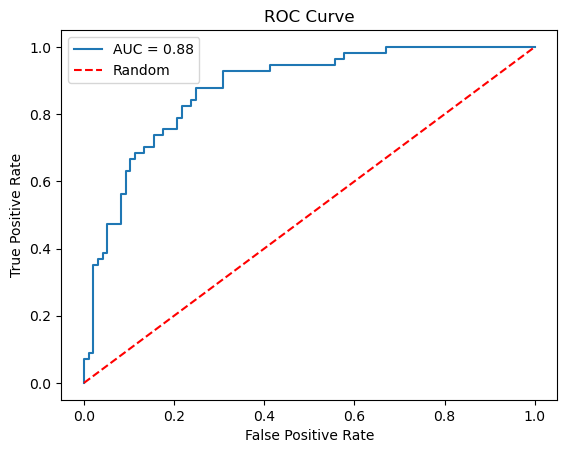

In [32]:
from sklearn.metrics import roc_curve, auc

# Lojistik Regresyon modelinin sınıf olasılıklarını al
y_prob = log_model.predict_proba(X_test)[:, 1]

# FPR, TPR ve eşik değerlerini hesapla
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# ROC eğrisini çiz
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


**AUC** skoru, bir sınıflandırma **modelinin performansını** ölçen önemli bir metriktir. 1'e yaklaşan bir AUC skoru, daha iyi bir performansı temsil eder.

In [33]:
# AUC skorunu hesapla
roc_auc_score(y_test, y_prob)

0.8755652016639537

### Model Validation: 5-Fold Cross Validation

**Model Doğrulama: 5 Kat Çapraz Doğrulama**

Modelimizi eğitim (%80) ve test (%20) olarak ayırdığımızda da elde ettiğimiz sonuçlar çok başarılı olmadı. Şimdi ise katlı çapraz doğrulama yöntemini kullanarak modelimizi eğitelim.

Veri setini eğitim ve test setleri olarak ayırmak yerine, veri seti farklı alt kümelerine bölünerek modelin birden çok kez eğitilip değerlendirilmesini sağlar. Bu yöntem, modelin genelleştirilebilirliğini kontrol etmek ve aşırı uyum sorunlarını önlemek için kullanılır. 

**Veri setimiz çok büyükse** önce veri setinin yukarıdaki gibi %80-20 ayrılması ve %80'lik veri ile katlı çapraz doğrulama yapılarak kalan %20 ile test yapılması önerilir. Fakat bizim burada veri setimiz yeterince büyük olmadığı için böyle bir ayırma işlemi yapmayacağız.

Bu kod, çapraz doğrulama yaparak modelin performansını değerlendirir. **cross_validate** fonksiyonu, belirtilen metrikler (accuracy, precision, recall, f1, roc_auc) için çapraz doğrulama sonuçlarını döndürür.

In [34]:
# Hedef değişkeni belirleme
y = df["Outcome"]

# Bağımsız değişkenleri seçme
X = df.drop(["Outcome"], axis=1)

# Lojistik Regresyon modelini eğitme
log_model = LogisticRegression().fit(X, y)

# Çapraz doğrulama sonuçlarını alma
cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,  # 5 katlı çapraz doğrulama
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

# Çapraz doğrulama sonuçlarını yazdırma
print("Accuracy:", cv_results["test_accuracy"])
print("Precision:", cv_results["test_precision"])
print("Recall:", cv_results["test_recall"])
print("F1 Score:", cv_results["test_f1"])
print("ROC AUC:", cv_results["test_roc_auc"])


Accuracy: [0.77272727 0.74675325 0.75324675 0.81699346 0.77124183]
Precision: [0.71111111 0.64705882 0.71052632 0.79069767 0.73684211]
Recall: [0.59259259 0.61111111 0.5        0.64150943 0.52830189]
F1 Score: [0.64646465 0.62857143 0.58695652 0.70833333 0.61538462]
ROC AUC: [0.81277778 0.80888889 0.825      0.87339623 0.84358491]


In [35]:
# Çapraz doğrulama sonuçlarından doğruluk skorlarının ortalamasını hesapla
cv_results['test_accuracy'].mean()


0.7721925133689839

In [36]:
# Çapraz doğrulama sonuçlarından hassasiyet skorlarının ortalamasını hesapla
cv_results['test_precision'].mean()


0.7192472060223519

In [37]:
# Çapraz doğrulama sonuçlarından duyarlılık skorlarının ortalamasını hesapla
cv_results['test_recall'].mean()


0.5747030048916841

In [38]:
# Çapraz doğrulama sonuçlarından F1 skorlarının ortalamasını hesapla
cv_results['test_f1'].mean()


0.6371421090986309

In [39]:
# Çapraz doğrulama sonuçlarından ROC AUC skorlarının ortalamasını hesapla
cv_results['test_roc_auc'].mean()


0.8327295597484277

Çapraz doğrulama ile elde etmiş olduğumuz ortalama başarı parametrelerini kontrol ederek. Daha önce oluşturmuş olduğumuz modellerin başarılı olup olmadığını yorumlayabiliriz. Eğer elde ettiğimiz başarı değerleri çapraz doğrulama ile elde edilen ortalama değerlerin altında ise kurduğumuz modeller daha da iyileştirilebilir demektir.

## Prediction for A New Observation
**Yeni Bir Gözlem İçin Tahmin**

Bu işlem, modelin belirli bir örneği nasıl tahmin ettiğini incelemek için yapılmıştır. Tahmin sonucu, örnek sınıf etiketi (örneğin, 0 veya 1) olarak dönecektir.

In [40]:
# Bağımsız değişkenlerin isimlerini yazdırma
X.columns


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [48]:
# Rastgele bir kullanıcı örneği seçme
random_user = X.sample(1, random_state=45)

# Lojistik Regresyon modelini kullanarak yeni tahmin yapma
new_preg = log_model.predict(random_user)

# Yeni tahmini ekrana yazdırır.
print(new_preg)

[1]


Rastgele seçilen bir kullancı, modelimiz tarafından diabet olarak tahmin edilmiştir. random_state değerini değiştirerek denemeler yapabilirsiniz.